In [1]:
#Import Modules 
import pandas as pd
import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

from tqdm import tqdm # Profiling 
from tqdm.gui import tqdm as tqdm_gui
import seaborn as sbn
import pickle, sys, importlib


function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import myFunctions as mf

In [2]:
from myFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

In [3]:
#Import Networks
net_civaux=pp.from_pickle(f'{network_folder}CIVAUX.p')
net_stlaurent=pp.from_pickle(f'{network_folder}ST LAURENT.p')

Compute the total power  of BT prod and Load on St Laurent 


In [4]:
# Compute the total of BT prod and Load on St Laurent
sum_max_p_mw_StLaurent_prodBT =net_stlaurent.sgen[net_stlaurent.sgen.name.isna()].max_p_mw.sum()
sum_max_p_mw_StLaurent_load = net_stlaurent.load.max_p_mw.sum()

In [5]:
row2read = 8784 # Total number of rows for year 2020

#Load files
file_p_inj_0013 = 'Prod_HTA/P0013/PROD-BATISOLAIRE 6-CIVAUX - Actif injecte (P-).csv'
file_p_inj_0018 = 'Prod_HTA/P0018/PROD-SUN POITOU 2516 (Z.I de la Pitage)-LHOMMAIZE - Actif injecte (P-).csv'

file_prod_bt_total = 'PROD_BTSUP36_SAINT LAURENT.csv'
file_cons_total = 'CONSO_POSTE_SAINT LAURENT.csv'

# The  commissioning of the Prod P0100 is recent (2022). I upscale the prod P0013 (*10)
# and consider it as that of Prod P0100
upscale_factor = 10


# Get files data 
p_mw_0013 = mf.readAndReshape_input(file_p_inj_0013 ,excel_folder, row2read)
p_mw_0018 = mf.readAndReshape_input(file_p_inj_0018 ,excel_folder, row2read)
p_mw_0100 = p_mw_0013*upscale_factor
p_mw_prod_bt_total = mf.readAndReshape_input(file_prod_bt_total, excel_folder)
p_mw_cons_total = mf.readAndReshape_input(file_cons_total, excel_folder)

# Create index to use for dataframe
per_index = pd.period_range('01 01 2020', periods=len(p_mw_0013), freq='10T')


# Create dict for all HT producers
dict_prod_hv = {'P0013': p_mw_0013, 
                'P0018': p_mw_0018,
                'P0100': p_mw_0100}

# Use the create dict to create a dataFrame for all HT producers
df_prodHT = pd.DataFrame(dict_prod_hv, index=per_index)

# Dataframe prod BT 
df_prod_bt_total = pd.DataFrame(p_mw_prod_bt_total, index=per_index, columns=['Prod_BT'])

# Dataframe Conso BT 
df_cons_total = pd.DataFrame(p_mw_cons_total, index=per_index, columns=["Load"])

# Get total Power of BT producers
# Bt producers are indexed by the name None
max_p_mw_total_prodBT = net_civaux.sgen.max_p_mw[net_civaux.sgen.name.isna()].sum()

# Get total power of load in the network
max_p_mw_total_load = net_civaux.load.max_p_mw.sum()

#### Plot Total prod BT and Total Load demand

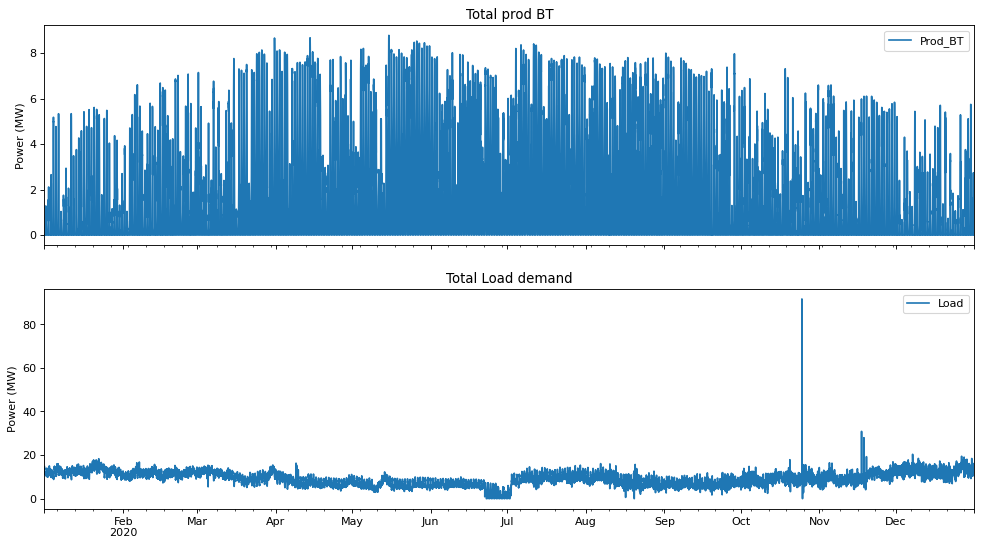

In [6]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total.plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

In the previous figure, the pic of demand occurring toward the end of October does not make sense. The disparity is undoubtedly due to a recording error. We will replace the recorded value with the mean of the two previous and following periods

In [7]:
max_indx = df_cons_total.Load.argmax()  # Get the indice of the period where the pic occurs

# replace the value with the mean of the previous and following periods
df_cons_total.Load[max_indx] = (df_cons_total.Load[max_indx-2: max_indx].sum()
                                + df_cons_total.Load[max_indx+1:max_indx+3].sum())/2

In [8]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prod_bt_total.plot(ax=axx[0], label = 'prod_bt_total', ylabel='Power (MW)', title='Total prod BT' )
df_cons_total.plot(ax=axx[1], label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Zoom on the end of june of the total demand

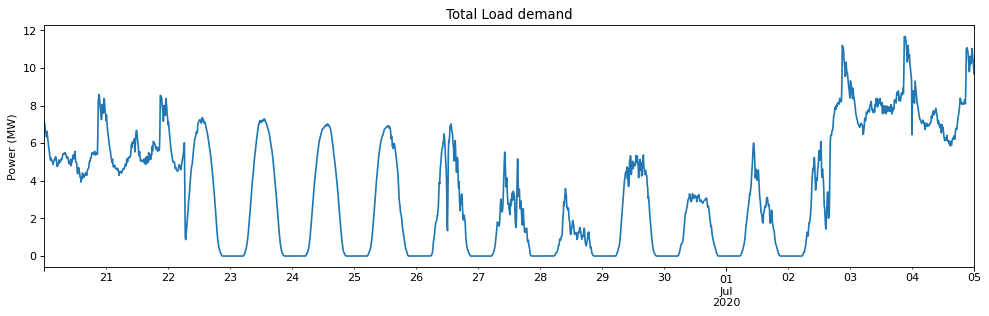

In [9]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total.Load[bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

<div class="alert alert block alert-danger ">
    <b>Important:</b> Total load demand follows a PV production cycle like from 2020-06-22 to 2020-07-03 included   
</div>    

#####  Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [10]:
previous_days = df_cons_total[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_cons_total[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]
# Put the interpolated data into the dataframe
df_cons_total[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                              np.array(previous_days) )/2

#### Check wether the wrong data have been replaced

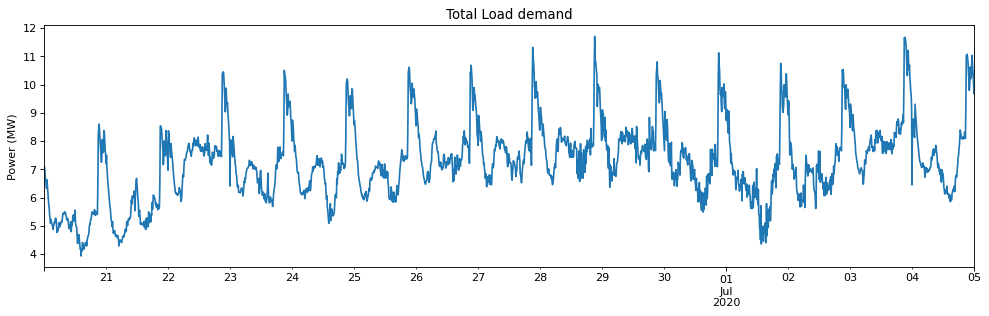

In [11]:
plt.figure(figsize=(15,4),dpi=80) 
bool_cond = (per_index >= '06 20 2020') & (per_index <= '07 05 2020' )
df_cons_total.Load[bool_cond].plot(label = 'prod_bt_total', ylabel='Power (MW)', title='Total Load demand');

#### Plot Total prod HT 

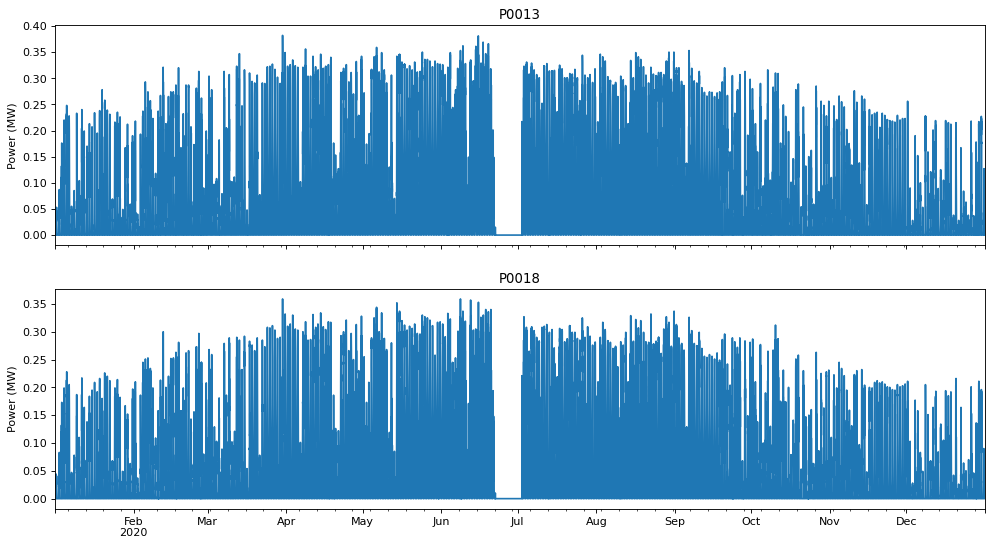

In [12]:
fig, axx = plt.subplots(2, figsize=(15,8),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');

### Highlight where data is missing

<AxesSubplot:>

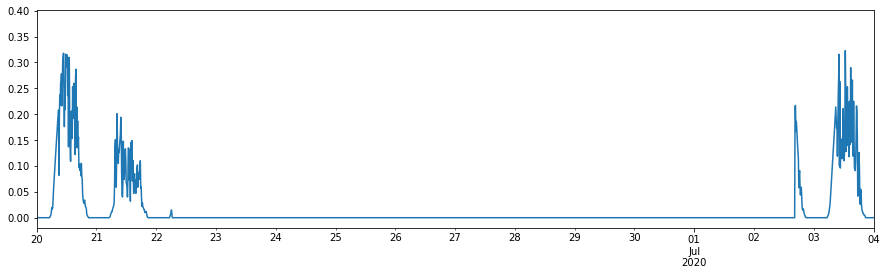

In [13]:
df_prodHT['P0013'].plot(xlim=('06 20 2020', '07 04 2020'), figsize=(15,4))

<div class="alert alert-block alert-danger">
<b>IMPORTANT:</b>
11 Days of data are missing (06-22 to 07-03)
</div>

##### Use the mean of data from the 11 surrounding days from both side to reconstruct it., i.e. 06-11 to 06-21 and 07-03 to 07-13

In [14]:
# Extract previous and following days 
previous_days = df_prodHT[(per_index>='2020 06 11') & (per_index<='2020 06 21 23:50')]
following_days = df_prodHT[(per_index>='2020 07 03') & (per_index<='2020 07 13 23:50')]

# Put the interpolated data into the dataframe
df_prodHT[(per_index>='2020 06 22') & (per_index<='2020 07 02 23:50')] = (np.array(following_days) + 
                                                                          np.array(previous_days) )/2

### Replot data to verify

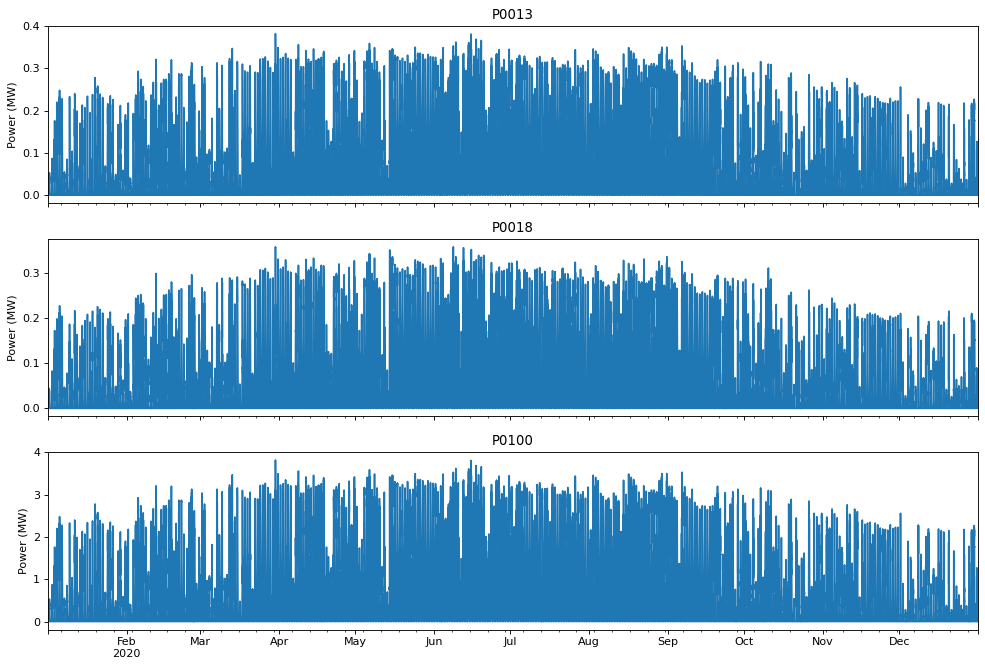

In [15]:
fig, axx = plt.subplots(3, figsize=(15,10),dpi=80, sharex=True) 
df_prodHT['P0013'].plot(ax=axx[0], title='P0013', ylabel='Power (MW)')
df_prodHT['P0018'].plot(ax=axx[1], title='P0018', ylabel='Power (MW)');
df_prodHT['P0100'].plot(ax=axx[2], title='P0100', ylabel='Power (MW)');

#### Extract activated bus 

In [16]:
net_civaux_hv_bus = list(net_civaux.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

#### Load data from simulation made in [Res_Sim_STLaurentDeJourdes](Res_Sim_STLaurentDeJourdes.ipynb)

In [17]:
file_loc = 'pickle_files/simulationResults/'

with open(file_loc+"STLaurentDeJourdes.pkl", 'rb') as file:
    STLaurentDeJourdes_dict = pickle.load(file)

In [18]:
list_max_vm_pu = STLaurentDeJourdes_dict['list_max_vm_pu']
list_index_max_vm_pu = STLaurentDeJourdes_dict['list_index_max_vm_pu']

max_vm_pu_df = pd.DataFrame(data=list_max_vm_pu, index=per_index, columns=['max_vm_pu'])

net_civaux1=pp.from_pickle(f'{network_folder}CIVAUX.p') #  Reload network with new name 
list_max_vm_pu1 = STLaurentDeJourdes_dict['list_max_vm_pu1']
max_vm_pu_df1 = pd.DataFrame(data=list_max_vm_pu1, index=per_index, columns=['max_vm_pu'])



net_civaux2=pp.from_pickle(f'{network_folder}CIVAUX.p') # Reload network with new name 
vm_mu_max, vm_mu_min = 1.0225, 0.95  # Choose 
list_max_vm_pu2 = STLaurentDeJourdes_dict['list_max_vm_pu2']
list_sgen_HT = STLaurentDeJourdes_dict['list_sgen_HT']
max_vm_pu_df2 = pd.DataFrame(data=list_max_vm_pu2, index=per_index, columns=['max_vm_pu'])


In [19]:
net_civaux1_hv_bus = list(net_civaux1.bus.groupby('vn_kv'))[1][1] # Extract HV bus in the network

pp.runpp(net_civaux1) # Run network 

# Get the index of all the activated bus in the network
activated_bus_index1 = list(net_civaux1.res_bus.vm_pu[net_civaux1.res_bus.vm_pu.notna()].index)

# Extract the HV bus from the list of activated bus 
net_civaux1_hv_activated_bus = [i for i in activated_bus_index1 
                               if i in net_civaux1_hv_bus.index]

## Run optimal power flow 

#### Load data from simultion file

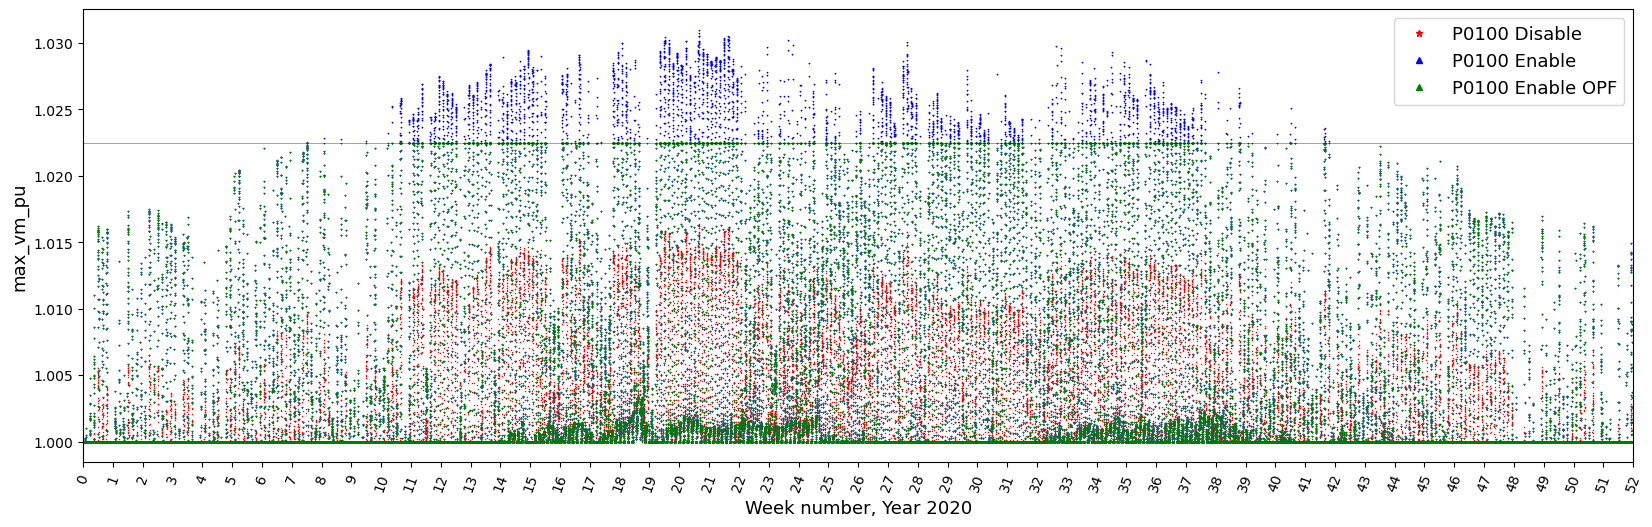

In [24]:
plt.figure(figsize=(20,6), dpi=100)
plt.plot(range(len(max_vm_pu_df1)), max_vm_pu_df1.values,'r*', markersize=0.5, label='P0100 Disable')
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df.values,'b^', markersize=0.5, label='P0100 Enable')
plt.plot(range(len(max_vm_pu_df)), max_vm_pu_df2.values,'g^', markersize=0.5, label='P0100 Enable OPF')

nb_per_days = 6*24 # Total number of periods whitin a day
nb_per_week = nb_per_days*7
plt.xticks(range(0,len(max_vm_pu_df1), nb_per_week), labels=range(52+1),rotation=70);
plt.xlabel('Week number, Year 2020', fontsize=13)
plt.ylabel('max_vm_pu', fontsize=13)
plt.legend(fontsize=13, markerscale=10)

week_start, week_end = 0, 52
xlim_start, xlim_end = 144*7*week_start, 144*7*week_end
plt.xlim([xlim_start, xlim_end])
# plt.ylim([1,1.020])
plt.axhline(vm_mu_max,color='k', lw=0.5, alpha=0.5)

In [25]:
prod_no_curt_mwh = df_prodHT['P0100'].sum()*Δt  # P0100 energy production when not curtailed
prod_curt_mw = np.array(list_sgen_HT)[:,2]                # P0100 power production after curtailement
prod_curt_mwh = prod_curt_mw.sum(axis=0)*Δt     # P0100 energy production after curtailed
df_prod_curt_mw = pd.DataFrame(data=prod_curt_mw, index=per_index, columns=['P0100_curt'])

# Percentage of power not injected into the grid during the year considered
perc_not_injected_mw = np.round((df_prodHT['P0100']-prod_curt_mw)*100/df_prodHT['P0100'], decimals=2)

# Percentage of energy not injected into the grid during the year considered
perc_not_injected_mwh = np.round((prod_no_curt_mwh-prod_curt_mwh)*100/prod_no_curt_mwh, decimals=2)


df_prod_curt_mw[df_prod_curt_mw<1e-6]=0 # replace lower value (lower than 1wh) by 0


perc_not_injected = pd.DataFrame(np.zeros(len(per_index)),index=per_index)

perc_not_injected[df_prodHT.P0100>0] = (100*(df_prodHT.P0100[df_prodHT.P0100>0] - df_prod_curt_mw[df_prodHT.P0100>0].round(decimals=4).loc[:,'P0100_curt'])/
                                        df_prodHT.P0100[df_prodHT.P0100>0]).values.reshape((len(perc_not_injected[df_prodHT.P0100>0]),1))

print(f'P0100 prod,   No curting  : {prod_no_curt_mwh:.2f} MWh')
print(f'P0100 prod, With curting  : {prod_curt_mwh:.2f} MWh')
print(f'Percentage of total \n      energy not injected : {perc_not_injected_mwh} %')



P0100 prod,   No curting  : 5033.34 MWh
P0100 prod, With curting  : 4717.35 MWh
Percentage of total 
      energy not injected : 6.28 %


### Some other plots

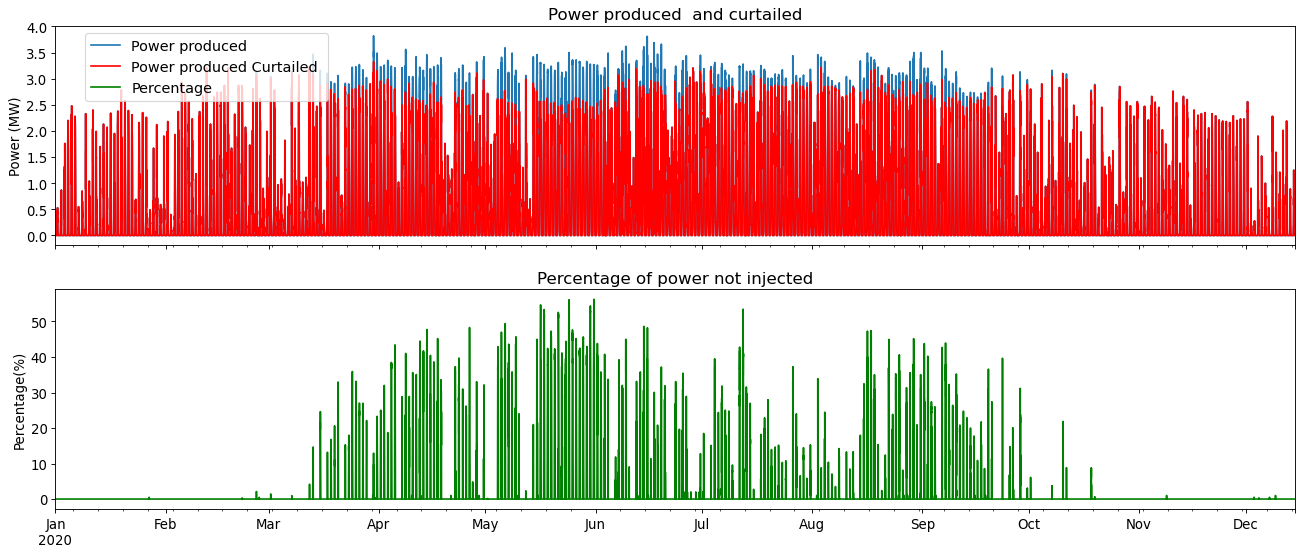

In [26]:
fig, axx = plt.subplots(2, figsize=(20,8), sharex=True, dpi=80)
df_prodHT.P0100.plot(ax=axx[0],legend=False)
df_prod_curt_mw.plot(ax=axx[0], color='red',
                     legend=False,fontsize=12,)
axx[0].set_title('Power produced  and curtailed',fontsize=15)
axx[0].set_ylabel('Power (MW)',fontsize=12)



perc_not_injected.plot(ax=axx[1], color="green", legend=False,
                       xlim=['2020 01 01', '2020 12 15'], fontsize=12,)
axx[1].set_title('Percentage of power not injected', fontsize=15)
axx[1].set_ylabel('Percentage(%)',fontsize=12)

fig.legend(['Power produced','Power produced Curtailed ', 'Percentage'],
          loc='upper right', 
           bbox_to_anchor=(0.3, 0.88), 
           ncol=1, fontsize=13)


# plt.grid(axis='both', which='Both')

#### Some other statistics

In [27]:
perc_not_injected[perc_not_injected<1e-6]=0 # Set to zero all the percentage value lower than (1w)

int_var = (perc_not_injected>0).sum()*100/(df_prodHT.P0100>1e-6).sum()# Actual period of production

# int_var = (perc_not_injected>0).sum()*100/len(perc_not_injected)
print('Percentage of time \n \twhen curtailement occurs :', np.round(int_var[0], decimals=2),'%')

Percentage of time 
 	when curtailement occurs : 11.28 %


#### Plot Stats about the percentage of power not injected into the grid

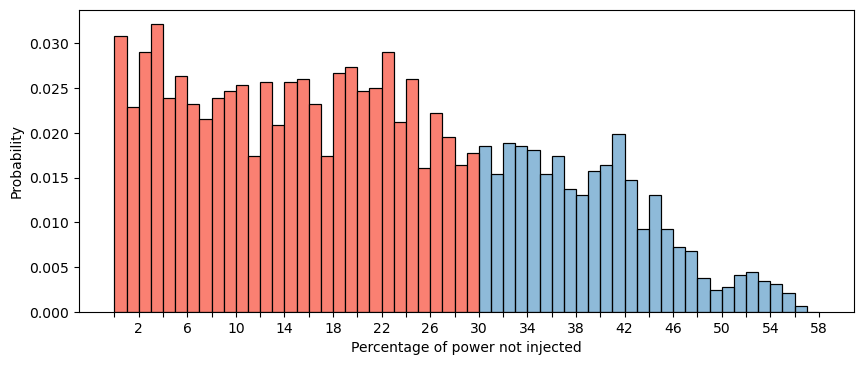

In [28]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=58, binrange=[0,58],
             stat='probability', ax=axx, cumulative= False,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        xticks=range(0,60,2), 
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);
for elm in axx.patches[:30]: elm.set_facecolor('salmon')

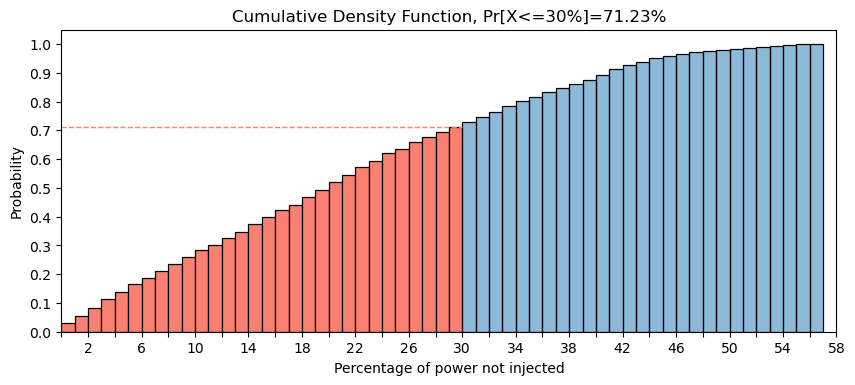

In [29]:
fig, axx = plt.subplots(1,1, figsize=(10,4), dpi=100)
sbn.histplot(perc_not_injected[perc_not_injected>0],bins=57, binrange=[0,57],
             stat='probability', ax=axx, cumulative=True,
             legend=False, color='red' )
axx.set(xlabel='Percentage of power not injected',
        yticks=np.arange(0,1.1,.1),
        xticks=range(0,60,2),
        xlim=(0,58),
        xticklabels=[i if elm%2==1 else '' for elm, i  in enumerate(range(0,60,2)) ]);

perc_to_consider= 30
for elm in axx.patches[:perc_to_consider]: elm.set_facecolor('salmon')

x_maxx = axx.patches[perc_to_consider].get_x()/58
axx.axhline(axx.patches[perc_to_consider-1].get_height(),xmax=x_maxx, color='salmon', ls='--', lw=1)
plt.title(f'Cumulative Density Function, Pr[X<={perc_to_consider}%]={axx.patches[perc_to_consider-1].get_height()*100:.2f}%');

### Build a neural network

In [30]:
df_prodHT.describe()

P0013         P0018         P0100
count  52704.000000  52704.000000  52704.000000
mean       0.057301      0.053682      0.573012
std        0.090124      0.085037      0.901240
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000
75%        0.087000      0.081000      0.870000
max        0.382000      0.359000      3.820000

In [31]:
df_input = pd.concat([df_cons_total, df_prod_bt_total, df_prodHT, df_prod_curt_mw], axis=1)
df_input.info()
df_input.describe()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 52704 entries, 2020-01-01 00:00 to 2020-12-31 23:50
Freq: 10T
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Load        52704 non-null  float64
 1   Prod_BT     52704 non-null  float64
 2   P0013       52704 non-null  float64
 3   P0018       52704 non-null  float64
 4   P0100       52704 non-null  float64
 5   P0100_curt  52704 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


Load       Prod_BT         P0013         P0018         P0100  \
count  52704.000000  52704.000000  52704.000000  52704.000000  52704.000000   
mean       9.086214      1.468861      0.057301      0.053682      0.573012   
std        2.734030      2.240819      0.090124      0.085037      0.901240   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        6.867000      0.000000      0.000000      0.000000      0.000000   
50%        8.849000      0.009000      0.000000      0.000000      0.000000   
75%       11.155000      2.382000      0.087000      0.081000      0.870000   
max       30.867000      8.782000      0.382000      0.359000      3.820000   

         P0100_curt  
count  52704.000000  
mean       0.537039  
std        0.817086  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.869989  
max        3.326653

In [395]:
prod_no_curt_mwh

5033.336666666667

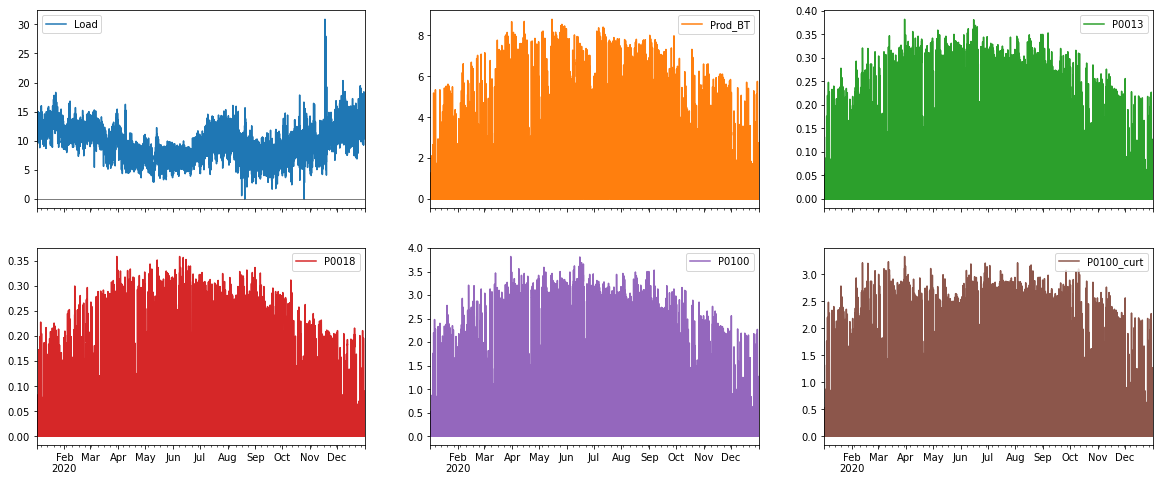

In [32]:
res = df_input.plot(subplots=True, figsize=(20,8), layout=(2,3));
res[0,0].axhline(0,color='k', lw=0.5)

#### Correlation between input and output

In [33]:
# Create a mask to extract daylight period. 
# We define the daylight period as the periods between the instants where either of the producers starts 
# injecting and when the last one stops injecting. 
daylight_mask = (df_input.P0013>0) | (df_input.P0018>0 ) | (df_input.P0100>0) | (df_input.Prod_BT>0)

In [34]:
df_input.loc[daylight_mask].corr()

Load   Prod_BT     P0013     P0018     P0100  P0100_curt
Load        1.000000 -0.382599 -0.347921 -0.368134 -0.347921   -0.312487
Prod_BT    -0.382599  1.000000  0.946429  0.954585  0.946429    0.914988
P0013      -0.347921  0.946429  1.000000  0.969539  1.000000    0.971582
P0018      -0.368134  0.954585  0.969539  1.000000  0.969539    0.940629
P0100      -0.347921  0.946429  1.000000  0.969539  1.000000    0.971582
P0100_curt -0.312487  0.914988  0.971582  0.940629  0.971582    1.000000

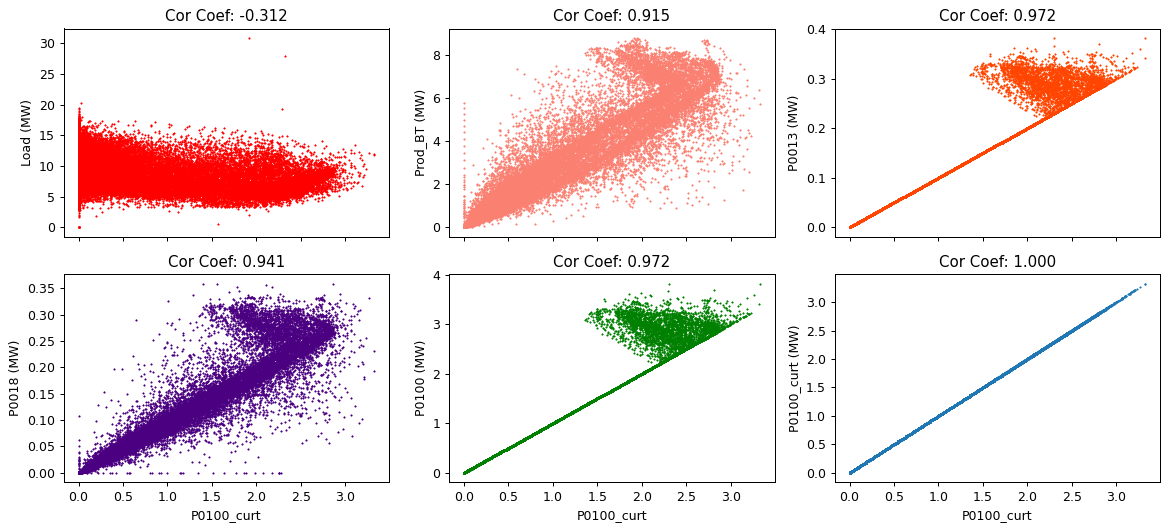

In [36]:
collor = ['red','salmon','orangered','indigo','green','tab:blue']
kwaargs = {'s':0.5, 'marker':'*', }
fig, axx = plt.subplots(2,3, figsize=(13,6), sharex=True, dpi=90)
for elm, ax_flat in enumerate(axx.flatten()):
    
    # Compute correlation and use its value as title
    val_to_plot =df_input.loc[daylight_mask].corr().at[df_input.columns[elm],'P0100_curt']

    df_input.plot(kind='scatter', ax=ax_flat,
                  x='P0100_curt', 
                  y=df_input.loc[daylight_mask].columns[elm],
                  color=collor[elm],
                  title= f'Cor Coef: { val_to_plot:.3f}',
                  **kwaargs)
    ax_flat.set(ylabel=ax_flat.get_ylabel()+' (MW)')
    
fig.tight_layout()

### Prepare data

In [37]:
## Add a new column to the input dataframe 
# Each row of the new column is True when curtailement is 
# occuring and false otherwise. 
# Capping is occuring solely when percentage of power not injected is >0
df_input['Capping'] = perc_not_injected>0

In [38]:
dependent_var_name = 'P0100_curt'       
independent_var_names = list(df_input.columns) 
independent_var_names.remove(dependent_var_name)

df_x = df_input.loc[daylight_mask][independent_var_names] # Extracting the independent variables
df_y = df_input.loc[daylight_mask][[dependent_var_name]]   # Extracting the dependent variable 

In [39]:
# from sklearnex import patch_sklearn
# patch_sklearn()

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
import sklearn.metrics as skl_mt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

#### Splitting data

In [460]:
aa, bb = train_test_split(df_x, shuffle=True)

In [467]:
pd.concat([aa, bb],axis=0)

Load  Prod_BT  P0013  P0018  P0100  Capping
2020-10-19 13:50   7.549    3.453  0.123  0.119   1.23    False
2020-06-25 12:00   6.688    6.810  0.268  0.234   2.68     True
2020-10-04 15:30   7.078    4.248  0.111  0.140   1.11    False
2020-03-07 08:10  12.530    0.327  0.009  0.009   0.09    False
2020-08-06 14:30   8.869    6.376  0.247  0.240   2.47    False
...                  ...      ...    ...    ...    ...      ...
2020-06-07 07:10   5.370    1.733  0.083  0.069   0.83    False
2020-11-10 17:00   8.008    0.188  0.005  0.003   0.05    False
2020-08-15 11:40   6.653    4.138  0.122  0.116   1.22    False
2020-07-22 16:20   8.702    4.840  0.196  0.200   1.96    False
2020-01-16 14:30   9.598    4.623  0.177  0.158   1.77    False

[27255 rows x 6 columns]

In [40]:
# Split data in training (80%) and test set (20%) using stratify sampling based 
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                   test_size=0.2,
                                                   stratify=df_x['Capping'])

# save capping instant in a new df. To use later
df_test_set_curt = x_test[['Capping']]

In [41]:
print('Training set' )
x_train[['Capping']].value_counts(normalize=True)

Training set


Capping
False      0.892772
True       0.107228
dtype: float64

In [42]:
print('Testing set' )
x_test[['Capping']].value_counts(normalize=True)

Testing set


Capping
False      0.89268
True       0.10732
dtype: float64

#### Remove capping column from splitted data

This is done because one cannot use whether capping occured or not as input for the model 
since at the prediction time one does not know yet. 

In [43]:
# Remove capping from independant variables
for x in [x_train, x_test]: x.drop(labels='Capping', axis=1, inplace=True)
    

🧠TODO : 
* Create an NN that predict capping or not.
* Use its output to fed another NN that predict curtailed Power
* Create an NN that predict directly the curtailed power without info about capping
* What is the best model between both previous ??

### Model 1 : Linear Regression

In [44]:
model = LinearRegression().fit(x_train, y_train)

In [45]:
print(f'Model Score: {model.score(x_test, y_test):.5} ')

Model Score: 0.94305 


In [227]:
y_pred = pd.DataFrame(model.predict(x_test),index=y_test.index, columns=['P0100_curt_Pred (LR)'])

<AxesSubplot:ylabel='Power (kW)'>

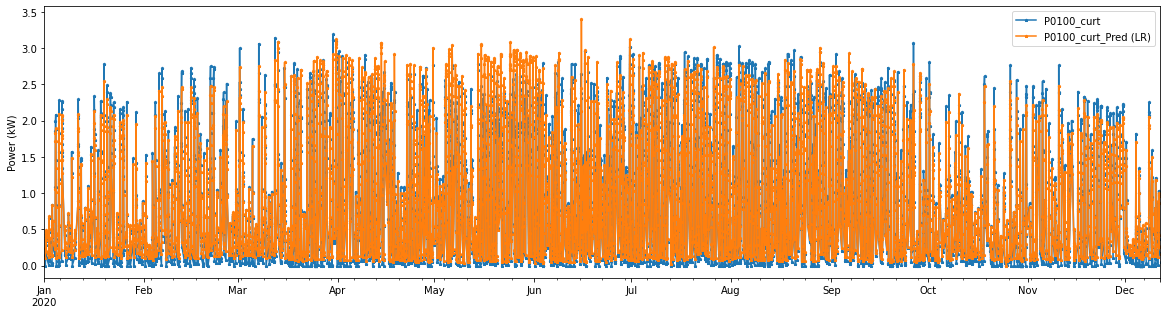

In [454]:
fig, axx = plt.subplots(sharex=True)
y_test.loc[y_test.index.sort_values()].plot(figsize=(20,5), ax=axx, marker='*',markersize=3)
y_pred.loc[y_pred.index.sort_values(), ['P0100_curt_Pred (LR)']].plot(figsize=(20,5),ax=axx, marker='*',markersize=3,
                                            xlim=('2020 01 01', '2020 12 12'), ylabel='Power (kW)')

In [451]:
abs_pred1_error = np.abs(y_pred['P0100_curt_Pred (LR)'] - y_test['P0100_curt'])
plt.figure(figsize=(10,5), dpi=90)
sbn.histplot(abs_pred1_error, bins=50,stat='count', log_scale=(False, True))
plt.xticks(np.linspace(0,1.5,16))
plt.xlabel('Power (MW)')

Text(0.5, 0, 'Power (MW)')

In [50]:
# Use mask to extract daylight period on predicted and actual production and compute mean absolute value
mae = skl_mt.mean_absolute_error(y_test, y_pred)

print(f'Mean absolute error between prediction and actual value = ± {mae*1000:.2f} kW')

Mean absolute error between prediction and actual value = ± 128.11 kW


### Model 2: 1 Hidden layer neural Network 

In [51]:
train_index = x_train.index
x_train.head()

Load  Prod_BT  P0013  P0018  P0100
2020-10-27 10:50  11.126    1.772  0.070  0.066   0.70
2020-11-10 08:20   9.422    0.058  0.001  0.000   0.01
2020-06-19 08:10   6.879    1.646  0.044  0.029   0.44
2020-05-25 14:00   5.838    8.153  0.311  0.306   3.11
2020-10-30 11:10   9.319    1.910  0.065  0.085   0.65

In [372]:
# Fitt and Get fitting  parameters to use later to inverse the transformation 
# of the training set 
fit_params_train_x = StandardScaler().fit(x_train)    
# fit_params_test_x = StandardScaler().fit(x_test)    

# transform training set before using in the neural network algorithm
x_train_scaled = fit_params_train_x.transform(x_train)
x_test_scaled = fit_params_train_x.transform(x_test)

#### Create Neural network

In [388]:
# Create a neaural network with a unique hidden layer of 128 neurones
ann = MLPRegressor(hidden_layer_sizes=(8,16,8,4), verbose=0, learning_rate='adaptive',tol=1e-6,)

# Train the neural network as defined
ann.fit(x_train_scaled, np.ravel(y_train));

#### Plot loss curve

In [389]:
# Check loss curve
fig, axx = plt.subplots()
plt.plot(ann.loss_curve_, '*-', markersize=2)
axx.set_yscale('log', base=10)

#### Predict based on the ANN

In [390]:
# predict using the test set
y = ann.predict(x_test_scaled)

# Add the predicted value to the predicted dataframe
y_pred['P0100_curt_Pred (NN1)'] = y

In [391]:
y_pred.head()

P0100_curt_Pred (LR)  P0100_curt_Pred (NN1)
2020-03-10 13:10              0.754296               0.754415
2020-07-09 15:30              2.100194               2.316090
2020-08-31 08:20              0.472153               0.471469
2020-07-31 13:50              2.353991               2.627119
2020-06-06 08:00              0.583184               0.613531

In [392]:
mae_nn1 = skl_mt.mean_absolute_error(y_test, y_pred['P0100_curt_Pred (NN1)'],)

print(f'Mean absolute error between prediction and actual value = ± {mae_nn1*1000:.2f} kW')

Mean absolute error between prediction and actual value = ± 3.87 kW


In [456]:
fig, axx = plt.subplots(sharex=True)
y_test.loc[y_test.index.sort_values()].plot(figsize=(20,5), ax=axx, )
y_pred.loc[y_pred.index.sort_values(), ['P0100_curt_Pred (NN1)'] ].plot(figsize=(20,5),ax=axx,
                                                                        ylabel='Power (MW)',
                                                                        xlim=('2020 01 01', '2020 12 12'));

In [1]:
abs_pred_error = np.abs(y_test.P0100_curt.values - y_pred['P0100_curt_Pred (NN1)'].values)
plt.figure(figsize=(10,5), dpi=90)
sbn.histplot(abs_pred_error, bins=50,stat='probability', log_scale=(False, True))
plt.xticks(np.linspace(0,.21,22), labels=range(0,22,1))
plt.xlabel('Prediction error (kW)'),

NameError: name 'np' is not defined